
Threshold value: 1.189
Number of high occupancy indices: 407
Number of low occupancy indices: 1209

High occupancy group bases:
         site  value base
0    111872.0  3.573    C
1    111864.0  3.527    A
2     32519.0  3.429    A
3     72817.0  3.426    C
4     44443.0  3.311    G
..        ...    ...  ...
402   68484.0  1.190    C
403  157301.0  1.189    A
404  173686.0  1.189    T
405  179711.0  1.189    C
406  191343.0  1.189    A

[407 rows x 3 columns]

Low occupancy group bases:
          site   value base
407    96976.0  1.1880    G
408    76477.0  1.1840    T
409   144341.0  1.1830    T
410   100239.0  1.1800    T
411   158223.0  1.1790    T
...        ...     ...  ...
1611   74995.0  0.0155    G
1612  151513.0  0.0155    A
1613  152126.0  0.0155    A
1614  152139.0  0.0155    T
1615  199915.0  0.0155    T

[1209 rows x 3 columns]

High Occupancy Group nucleotide percentages:
A base percentage: 28.99%
T base percentage: 26.78%
G base percentage: 23.83%
C base percentage: 20.

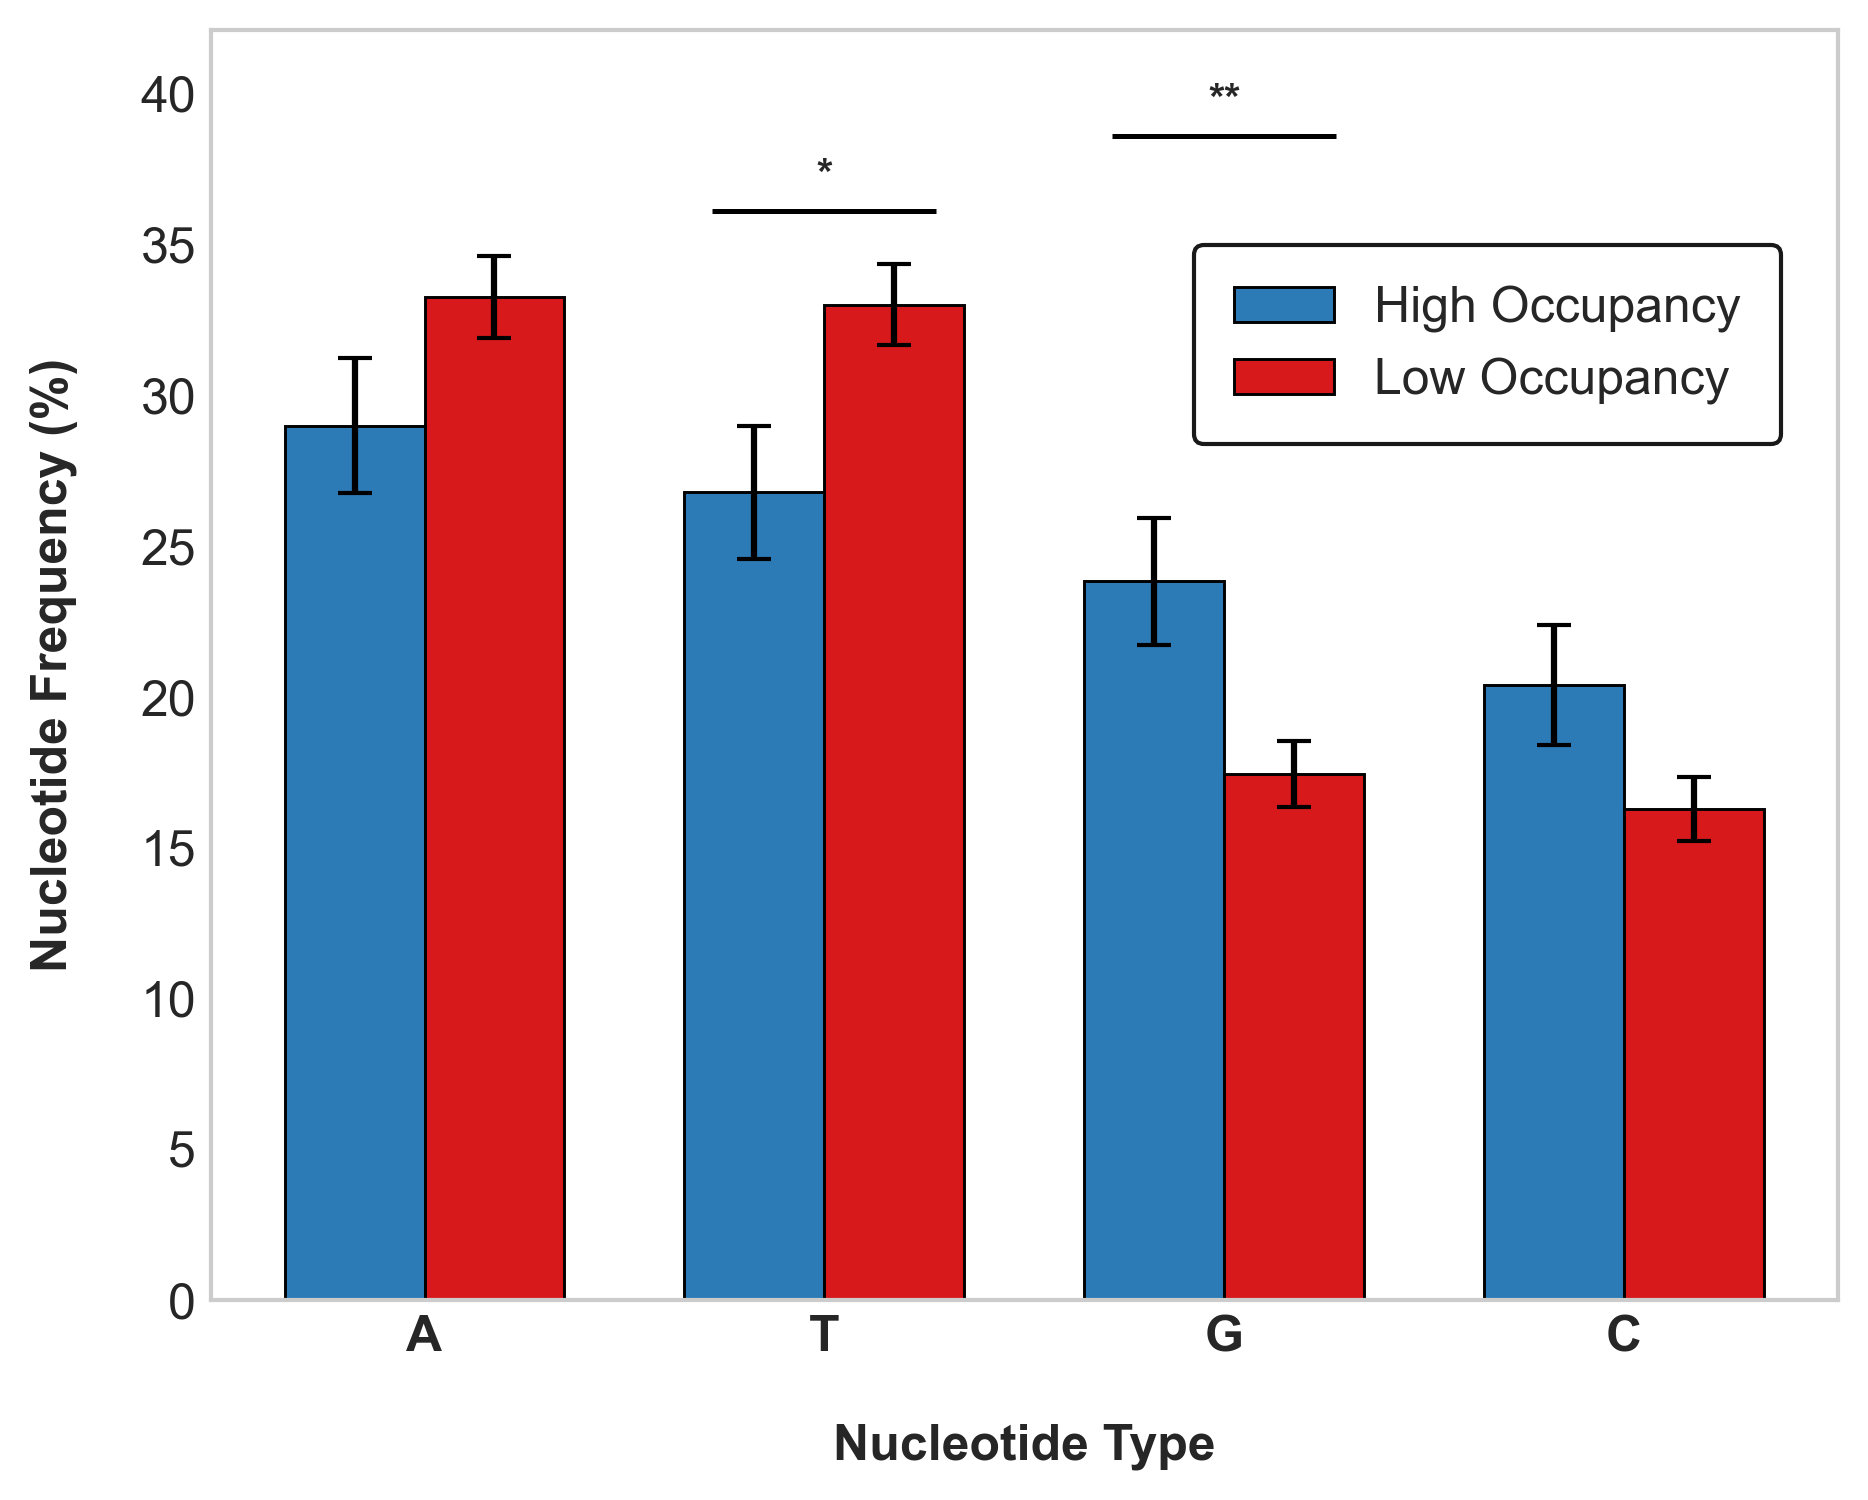

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import os

# =================================================
# 0. Global academic-figure parameters
# =================================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'errorbar.capsize': 4})

# =================================================
# 1. Load and process data
# =================================================
file_path = "Test Sites and Occupancy/ch1_testing.csv"
occupancy_data = pd.read_csv(file_path, usecols=[0, 1])

threshold = np.percentile(occupancy_data.iloc[:, 1], 75)
print(f"\nThreshold value: {threshold:.3f}")

high_occupancy_indices = occupancy_data.iloc[:, 1] >= threshold
low_occupancy_indices = occupancy_data.iloc[:, 1] < threshold

print(f"Number of high occupancy indices: {sum(high_occupancy_indices)}")
print(f"Number of low occupancy indices: {sum(low_occupancy_indices)}")

high_occupancy_group = occupancy_data[high_occupancy_indices].copy()
low_occupancy_group = occupancy_data[low_occupancy_indices].copy()

# =================================================
# 2. Extract nucleotide bases from genome sequence
# =================================================
genome_file_path = "SAC1 Genome Deletion of Spaces/CH1n.txt"
with open(genome_file_path, 'r') as file:
    genome_sequence = file.read().strip()

def extract_bases_from_genome(group, genome_sequence):
    bases = []
    for index, row in group.iterrows():
        position = int(row.iloc[0])
        if position >= len(genome_sequence):
            bases.append(None)
        else:
            bases.append(genome_sequence[position])
    return bases

high_occupancy_group['base'] = extract_bases_from_genome(high_occupancy_group, genome_sequence)
low_occupancy_group['base'] = extract_bases_from_genome(low_occupancy_group, genome_sequence)

print("\nHigh occupancy group bases:")
print(high_occupancy_group)
print("\nLow occupancy group bases:")
print(low_occupancy_group)

# =================================================
# 3. Single-nucleotide statistics & significance test
# =================================================
def calculate_nucleotide_data(sequences):
    counts = {'A': 0, 'T': 0, 'G': 0, 'C': 0}
    for base in sequences.dropna():
        if base in counts:
            counts[base] += 1
    total = sum(counts.values())
    percentages = {k: (v / total) * 100 if total > 0 else 0 for k, v in counts.items()}
    return counts, percentages, total

high_counts, high_percent, total_high = calculate_nucleotide_data(high_occupancy_group['base'])
low_counts, low_percent, total_low = calculate_nucleotide_data(low_occupancy_group['base'])

print("\nHigh Occupancy Group nucleotide percentages:")
for base in ['A', 'T', 'G', 'C']:
    print(f"{base} base percentage: {high_percent[base]:.2f}%")

print("\nLow Occupancy Group nucleotide percentages:")
for base in ['A', 'T', 'G', 'C']:
    print(f"{base} base percentage: {low_percent[base]:.2f}%")

def calculate_se(p_percent, n):
    p = p_percent / 100.0
    se = np.sqrt(p * (1 - p) / n) * 100 if n > 0 else 0
    return se

high_err = {base: calculate_se(high_percent[base], total_high) for base in ['A', 'T', 'G', 'C']}
low_err  = {base: calculate_se(low_percent[base],  total_low)  for base in ['A', 'T', 'G', 'C']}

p_values = {}
for base in ['A', 'T', 'G', 'C']:
    count = [high_counts[base], low_counts[base]]
    nobs  = [total_high, total_low]
    _, p = proportions_ztest(count, nobs, alternative='two-sided')
    p_values[base] = p

# =================================================
# 4. Single-nucleotide visualization (optimized)
# =================================================
nucleotides = ['A', 'T', 'G', 'C']
x = np.arange(len(nucleotides))
width = 0.35
color_high = '#2c7bb6'
color_low  = '#d7191c'

fig, ax = plt.subplots(figsize=(7, 5.5))

rects_high = ax.bar(x - width / 2,
                    [high_percent[base] for base in nucleotides],
                    width,
                    color=color_high,
                    edgecolor='black',
                    linewidth=0.7,
                    yerr=[high_err[base] for base in nucleotides],
                    label='High Occupancy')

rects_low = ax.bar(x + width / 2,
                   [low_percent[base] for base in nucleotides],
                   width,
                   color=color_low,
                   edgecolor='black',
                   linewidth=0.7,
                   yerr=[low_err[base] for base in nucleotides],
                   label='Low Occupancy')

def get_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'NS'

max_y = max([high_percent[base] + high_err[base] for base in nucleotides] +
            [low_percent[base] + low_err[base] for base in nucleotides])
y_start = max_y + 1.5
y_increment = 2.5

for i, base in enumerate(nucleotides):
    p = p_values[base]
    if p < 0.05:
        ax.hlines(y_start, x[i] - width * 0.8, x[i] + width * 0.8,
                  colors='black', linewidth=1.2, linestyles='solid')
        ax.text(x[i], y_start + 0.5, get_stars(p),
                ha='center', va='bottom', fontsize=10, fontweight='bold')
        y_start += y_increment

ax.set_ylabel('Nucleotide Frequency (%)', fontweight='bold', labelpad=15)
ax.set_xlabel('Nucleotide Type', fontweight='bold', labelpad=15)
ax.set_xticks(x)
ax.set_xticklabels(nucleotides, fontweight='bold')
ax.set_ylim(0, y_start + 1)

legend = ax.legend(frameon=True, framealpha=0.9, edgecolor='black',
                   loc='upper right', bbox_to_anchor=(0.98, 0.85), borderpad=0.8)
plt.setp(legend.get_title(), fontweight='bold')

ax.yaxis.grid(False)
ax.xaxis.grid(False)

save_path = os.path.join("Visualization Charts", "Single-Nucleotide-Preference-Barplot.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)   
plt.show()


Threshold value: 1.189
Number of high occupancy indices: 407
Number of low occupancy indices: 1209

High occupancy group bases:
         site  value base
0    111872.0  3.573    C
1    111864.0  3.527    A
2     32519.0  3.429    A
3     72817.0  3.426    C
4     44443.0  3.311    G
..        ...    ...  ...
402   68484.0  1.190    C
403  157301.0  1.189    A
404  173686.0  1.189    T
405  179711.0  1.189    C
406  191343.0  1.189    A

[407 rows x 3 columns]

Low occupancy group bases:
          site   value base
407    96976.0  1.1880    G
408    76477.0  1.1840    T
409   144341.0  1.1830    T
410   100239.0  1.1800    T
411   158223.0  1.1790    T
...        ...     ...  ...
1611   74995.0  0.0155    G
1612  151513.0  0.0155    A
1613  152126.0  0.0155    A
1614  152139.0  0.0155    T
1615  199915.0  0.0155    T

[1209 rows x 3 columns]


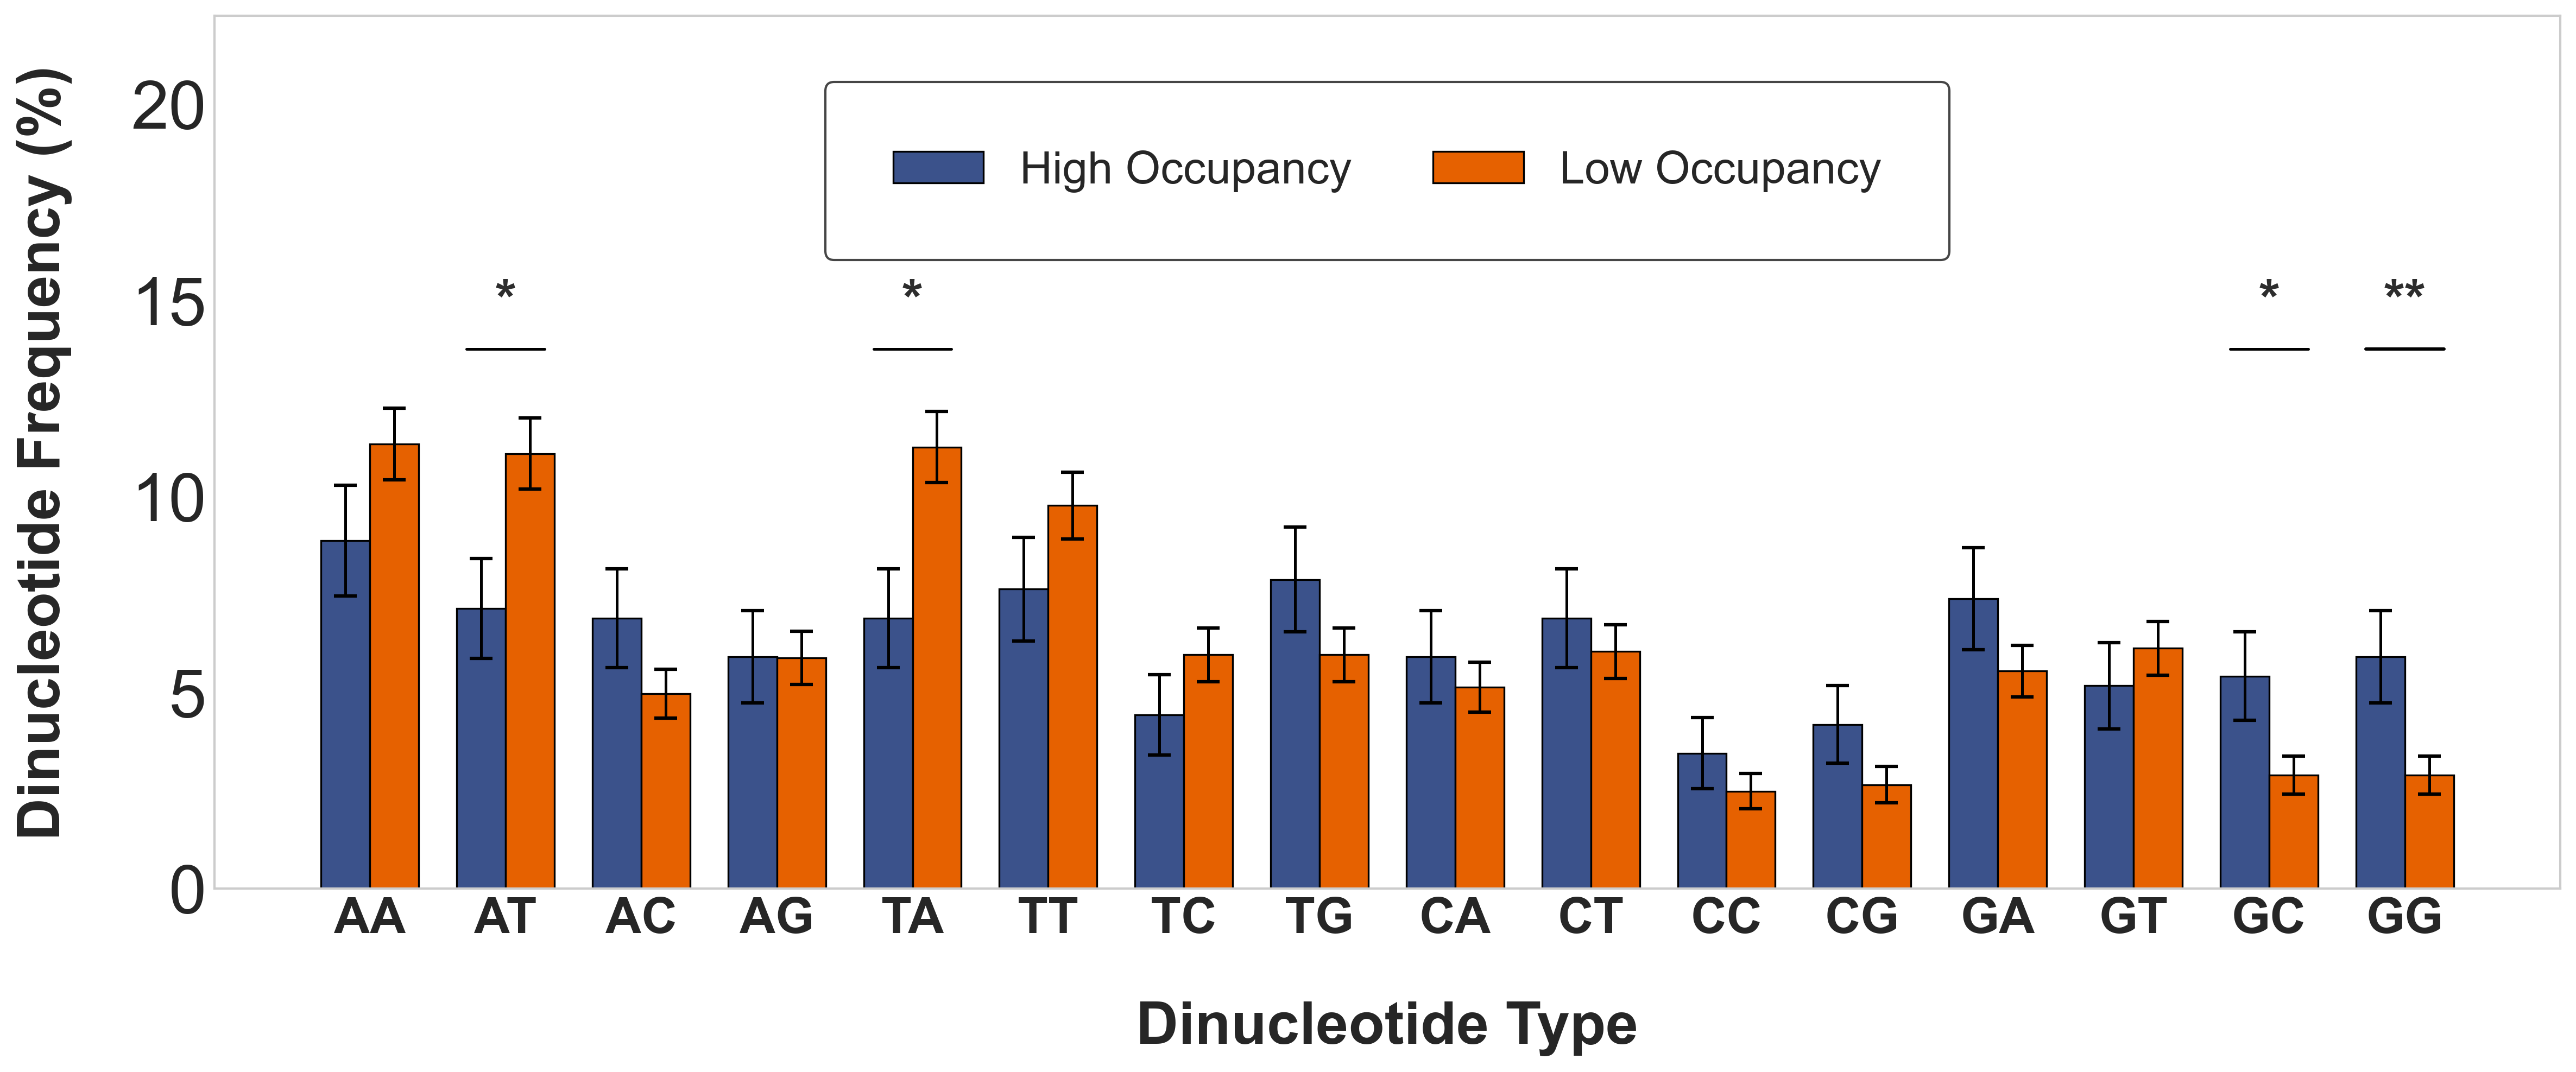

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import os

# =================================================
# 0. Global academic-figure parameter settings
# =================================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 30,
    'axes.titlesize': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 30,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'errorbar.capsize': 4})

# =================================================
# 1. Data loading and processing
# =================================================
file_path = "Test Sites and Occupancy/ch1_testing.csv"
occupancy_data = pd.read_csv(file_path, usecols=[0, 1])

threshold = np.percentile(occupancy_data.iloc[:, 1], 75)
print(f"\nThreshold value: {threshold:.3f}")

high_occupancy_indices = occupancy_data.iloc[:, 1] >= threshold
low_occupancy_indices = occupancy_data.iloc[:, 1] < threshold

print(f"Number of high occupancy indices: {sum(high_occupancy_indices)}")
print(f"Number of low occupancy indices: {sum(low_occupancy_indices)}")

high_occupancy_group = occupancy_data[high_occupancy_indices].copy()
low_occupancy_group = occupancy_data[low_occupancy_indices].copy()

# =================================================
# 2. Genome-sequence processing
# =================================================
genome_file_path = "SAC1 Genome Deletion of Spaces/CH1n.txt"
with open(genome_file_path, 'r') as file:
    genome_sequence = file.read().strip()

def extract_bases_from_genome(group, genome_sequence):
    bases = []
    for index, row in group.iterrows():
        position = int(row.iloc[0])
        if position >= len(genome_sequence):
            bases.append(None)
        else:
            bases.append(genome_sequence[position])
    return bases

high_occupancy_group['base'] = extract_bases_from_genome(high_occupancy_group, genome_sequence)
low_occupancy_group['base'] = extract_bases_from_genome(low_occupancy_group, genome_sequence)

print("\nHigh occupancy group bases:")
print(high_occupancy_group)
print("\nLow occupancy group bases:")
print(low_occupancy_group)

# =================================================
# 3. Dinucleotide statistical-analysis system
# =================================================
def calculate_dinucleotide_stats(sequences):
    dinucleotides = ['AA','AT','AC','AG','TA','TT','TC','TG','CA','CT','CC','CG','GA','GT','GC','GG']
    counts = {dn:0 for dn in dinucleotides}
    total = 0
    
    valid_sequences = [b for b in sequences if pd.notnull(b)]
    for i in range(len(valid_sequences)-1):
        dn = valid_sequences[i] + valid_sequences[i+1]
        if dn in counts:
            counts[dn] += 1
            total += 1
    
    percentages = {dn: (count/total)*100 if total>0 else 0 for dn, count in counts.items()}
    se = {dn: np.sqrt((p/100)*(1-p/100)/total)*100 if total>0 else 0 for dn, p in percentages.items()}
    
    return counts, percentages, se, total

high_counts, high_dn_percent, high_dn_se, high_total = calculate_dinucleotide_stats(high_occupancy_group['base'])
low_counts, low_dn_percent, low_dn_se, low_total = calculate_dinucleotide_stats(low_occupancy_group['base'])

# significance test
dn_pvalues = {}
for dn in high_dn_percent.keys():
    count = [high_counts[dn], low_counts[dn]]
    nobs = [high_total, low_total]
    _, p = proportions_ztest(count, nobs, alternative='two-sided')
    dn_pvalues[dn] = p

# =================================================
# 4. Dinucleotide advanced-visualization system
# =================================================
COLOR_PALETTE = {'high': '#3B528B', 'low': '#E66100'}

SIGNIFICANCE_LEVELS = {0.001: ('***', 1.4), 0.01: ('**', 1.2),0.05: ('*', 1.0)}

fig, ax = plt.subplots(figsize=(16, 8), dpi=300) 
plt.subplots_adjust(left=0.07, right=0.97, top=0.92, bottom=0.25)

dinucleotides = ['AA','AT','AC','AG','TA','TT','TC','TG','CA','CT','CC','CG','GA','GT','GC','GG']
x = np.arange(len(dinucleotides))
width = 0.36
bar_params = {'linewidth': 0.8,'edgecolor': 'black','error_kw': {'elinewidth': 1.2,'capthick': 1.5,'capsize': 5}}

high_bars = ax.bar(x - width/2, [high_dn_percent[dn] for dn in dinucleotides],
                   width, color=COLOR_PALETTE['high'],
                   yerr=[high_dn_se[dn] for dn in dinucleotides],
                   label='High Occupancy', **bar_params)

low_bars = ax.bar(x + width/2, [low_dn_percent[dn] for dn in dinucleotides],
                  width, color=COLOR_PALETTE['low'],
                  yerr=[low_dn_se[dn] for dn in dinucleotides],
                  label='Low Occupancy', **bar_params)

def auto_annotation(ax, pvalues, y_base):
    y_levels = {}
    for idx, (dn, p) in enumerate(pvalues.items()):
        if p >= 0.05:
            continue
        
        symbol, line_scale = '', 1.0
        
        for cutoff in sorted(SIGNIFICANCE_LEVELS.keys()):
            if p < cutoff:
                symbol, line_scale = SIGNIFICANCE_LEVELS[cutoff]
                break
        
        if not symbol:
            continue
            
        x_pos = x[idx]
        current_y = y_base
        while (x_pos, current_y) in y_levels:
            current_y += 3
        
        y_levels[(x_pos, current_y)] = True
        
        ax.plot([x_pos - width*0.8, x_pos + width*0.8],
                [current_y, current_y], 
                color='black', 
                linewidth=1.2*line_scale,
                solid_capstyle='round')
        
        ax.text(x_pos, current_y + 0.8, symbol,
                ha='center', va='baseline',
                fontsize=24, fontweight='bold',
                color='#2d2d2d')

max_y = max([h + e for h, e in zip(high_dn_percent.values(), high_dn_se.values())] +
         [l + e for l, e in zip(low_dn_percent.values(), low_dn_se.values())])
auto_annotation(ax, dn_pvalues, y_base=max_y + 1.5)

ax.set_ylim(0, max_y + 10)  
ax.set_ylabel('Dinucleotide Frequency (%)', 
              fontsize=26, fontweight='bold', labelpad=26)
ax.set_xlabel('Dinucleotide Type', 
              fontsize=26, fontweight='bold', labelpad=26)
ax.set_xticks(x)
ax.set_xticklabels(dinucleotides, 
                  rotation=0,
                  ha='center',
                  fontsize=22,
                  fontweight='semibold')

legend = ax.legend(
    frameon=True,
    framealpha=0.97,
    edgecolor='#404040',
    facecolor='white',
    fontsize=20,
    ncol=2,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.95),
    borderpad=1.5,
    columnspacing=1.8)

plt.setp(legend.get_texts(), fontsize='20')
plt.setp(legend.get_title(), fontsize='20')

ax.yaxis.grid(False)
ax.xaxis.grid(False)

save_path = os.path.join("Visualization Charts", "Dinucleotide-Preference-Barplot.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()